In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, model_selection, feature_selection, pipeline, ensemble, tree
from sympy import *
from sympy.stats import *

## Tasniflendirmede varsayimlar

In [2]:
from sklearn import datasets
import scipy.stats as scs
from ipywidgets import interact

In [3]:
np.random.seed(23)
X = np.random.randn(100, 2)
xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3.5, 100))

Datasetimizi sabitleyelim.

In [4]:
b = np.array([4.0, 3.9])
intersept = 0.0
z = X @ b + intersept
# her orneklem icin etiketi belirleyecek olan Bernoulli dagiliminin p parametreleri
berno = 1 / (1 + np.exp(-z))  # Bu fonksiyonun ne oldugu simdilik onemsiz

In [5]:
y = scs.bernoulli.rvs(p=berno)

### Hipotezimizin logit kismi: g(x)

`Tasniflendirme icin MLE` kisminda hipotez fonksiyonumuzun

$$h(x) = \frac{1}{1 + e^{-g(x)}}$$

seklinde ifade edilebileceginden bahsedip, logit kismi $g(x)$ icin lineer bir fonksiyon ($g(x) = {X\beta}$) kullanarak bir tasniflendirme denemesi yaptik.

Eger zincir kuralini kullanacaksak, $g(x)$'i daha kompleks (ve daha guclu) bir hale getiremez miyiz?



Ornegin, asagidaki gibi cok katmanli bir sistem, benzer adimlar izleyerek optimize edilebilir mi?

$$Z_1 = X\beta_1 + sabit_1$$
$$A_1 = \sigma(Z_1) $$
> Buraya kadarki kismi lojistik regresyonda uygulamistik ($\hat{Y} = \sigma(Z_1)$)
$$Z_2 = A_1\beta_2 + sabit_2$$
$$\hat{Y} = \sigma(Z_2)$$

![](graph.png)

## Cok katmanli perceptron (MLP - multilayer perceptron)

Cok katmanli perceptron icin, yukaridaki semayi baz alarak bir sistem kurabiliriz.

Ihtiyacimiz olanlar:
- $\beta_1$
- $sabit_1$
- $\beta_2$
- $sabit_2$

Tamamen rastgele secilmis agirliklarla bir deneme yapalim.

In [6]:
beta1 = np.array([[-5.0, 2.5], [1.0, 1.0]])
sabit1 = np.array([0.0, 0.0])
beta2 = np.array([-5.0, 2.5])
sabit2 = 0.0

Hipotez fonksiyonumuzu asagidaki gibi yazabiliriz:

In [7]:
def forward(X, beta1, sabit1, beta2, sabit2):
    z1 = X @ beta1 + sabit1
    a1 = 1 / (1 + np.exp(-z1))
    z2 = a1 @ beta2 + sabit2
    return z2

Hipotez fonksiyonumuzun ciktisi:

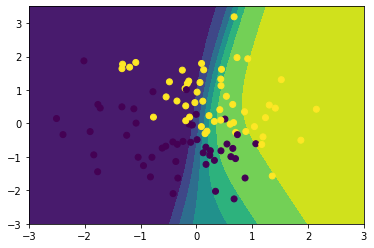

In [8]:
z = forward(np.array([xx.ravel(), yy.ravel()]).T, beta1, sabit1, beta2, sabit2)
olasi = 1 / (1 + np.exp(- z))
olasi = olasi.reshape(xx.shape)

plt.contourf(xx, yy, olasi)
plt.scatter(*X.T, c=y);

Cok katmanli perceptron ile ilgili hipotez fonksiyonunda (Lojistik Regresyon'a kiyasla) gozumuze ilk carpan detay nedir?

Cok katmanli perceptron'umuzun ciktisini hesaplamak icin kullandigimiz adimlari yazarsak:

(sigmoid fonksiyonunu $\sigma(x)$ olarak gostererek)

$$Z_1 = X \beta_1 + sabit_1$$
$$A_1 = \sigma(Z_1) $$
$$Z_2 = A_1 \beta_2 + sabit_2$$
$$A_2 = \sigma(Z_2)$$
$$\hat{Y} = A_2$$
$$ J(\hat{Y}) = \sum_{i=0}^{m-1}{-Y_i \log{\hat{Y}_i} - (1 - Y_i) \log{(1 - \hat{Y}_i)}} $$

Lojistik regresyonda kullandigimiz zincir kurali ile bu sistemi de optimize edebilir miyiz?

$$ \frac{dJ}{d\beta_2} = \frac{dJ}{d\hat{Y_i}} \frac{d \hat{Y_i}}{d Z_2} \frac{d Z_2}{d \beta_2}$$
$$ \frac{dJ}{dsabit_2} = \frac{dJ}{d\hat{Y_i}} \frac{d \hat{Y_i}}{d Z_2}$$
$$ \frac{dJ}{d\beta_1} = \frac{dJ}{d\hat{Y_i}} \frac{d \hat{Y_i}}{d Z_2} \frac{d Z_2}{d A_1} \frac{d A_1}{d Z_1} \frac{dZ_1}{d\beta_1}$$
$$ \frac{dJ}{dsabit_1} = \frac{dJ}{d\hat{Y_i}} \frac{d \hat{Y_i}}{d Z_2} \frac{d Z_2}{d A_1} \frac{d A_1}{d Z_1}$$

Bazi parametrelerin turevlerinin ilk sistemimizden hicbir farki olmadigini gorurken, sistemde geriye (semada sol tarafa) gittikce yalnizca ek carpanlar eklendigini goruyoruz.

Bir iterasyon icin guncelleme kuralimizi yazalim:

##### Baslatma

Parametrelerimiz icin baslangic degerleri secelim (rastgele degerler sectik):

In [9]:
beta1 = np.array([[-5.0, 2.5], [1.0, 1.0]])
sabit1 = np.array([0.0, 0.0])
beta2 = np.array([[-5.0], [2.5]])
sabit2 = 0.0
alpha = 1e-1 # Ogrenme orani

Vektor islemlerimiz icin hedef degisken `y`'yi kolon vektor haline getirelim:

In [10]:
y1 = y[:, None]

##### Ileri besleme

Bu kisimda orneklerimizi, sistemimizde ilerleterek tahminimizi yapacagiz

In [11]:
def sigmoid(x):
    """Sigmoid aktivasyon fonksiyonu"""
    return 1 / (1 + np.exp(-x))

def bce(y, yhat):
    """Ikili capraz-entropi (binary cross entropy) maliyet fonksiyonu."""
    return -(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))

In [12]:
z1 = X @ beta1 + sabit1
a1 = sigmoid(z1)
z2 = a1 @ beta2 + sabit2
yhat = sigmoid(z2)

Baslangic maliyetimiz:

In [13]:
bce(y1, yhat).sum()

96.3087695134783

##### Geri yayilim (Backpropagation)

Bu kisimda ise, ortaya cikan hatanin turevini geri dogru zincirleme bir sekilde alacagiz

In [14]:
dyhat = (1 - y1) / (1 - yhat) - (y1 / yhat)
dz2 = yhat * (1 - yhat) * dyhat

dbeta2 = a1.T @ (dz2)
dsabit2 = (dz2).sum()

da1 = dz2 @ beta2.T
dz1 = a1 * (1 - a1) * da1

dbeta1 = X.T @ dz1
dsabit1 = dz1.sum(axis=0)

Guncellemelerimizi yapalim:

In [15]:
beta1 = beta1 - alpha * dbeta1
sabit1 = sabit1 - alpha * dsabit1

beta2 = beta2 - alpha * dbeta2
sabit2 = sabit2 - alpha * dsabit2

Yeni maliyetimizi kontrol edelim:

In [16]:
# ileri besleme
z1 = X @ beta1 + sabit1
a1 = sigmoid(z1)
z2 = a1 @ beta2 + sabit2
yhat = sigmoid(z2)

# hata hesaplama
bce(y1, yhat).sum()

57.84821372581541

Parcalari birlestirip, guncellememizi verilen bir iterasyon sayisi kadar tekrar edelim:

In [17]:
np.random.seed(42)
beta1 = np.array([[-5.0, 2.5], [1.0, 1.0]])
sabit1 = np.array([0.0, 0.0])
beta2 = np.array([[-5.0], [2.5]])
sabit2 = 0.0
maliyetler = []
alpha = 1e-1
# betayolu = [beta]
iterasyon = 20

for _ in range(iterasyon):
    z1 = X @ beta1 + sabit1
    a1 = sigmoid(z1)
    z2 = a1 @ beta2 + sabit2
    yhat = sigmoid(z2)

    dyhat = (1 - y1) / (1 - yhat) - (y1 / yhat)
    dz2 = yhat * (1 - yhat) * dyhat

    dbeta2 = a1.T @ (dz2)
    dsabit2 = (dz2).sum()

    da1 = dz2 @ beta2.T
    dz1 = a1 * (1 - a1) * da1

    dbeta1 = X.T @ dz1
    dsabit1 = dz1.sum(axis=0)

    beta1 = beta1 - alpha * dbeta1
    sabit1 = sabit1 - alpha * dsabit1

    beta2 = beta2 - alpha * dbeta2
    sabit2 = sabit2 - alpha * dsabit2

    # dbeta = X.T @ (  ((1 - y)/(1 - yhat) - y/yhat) * (1 - yhat) * yhat )
    # dsabit = (  ((1 - y)/(1 - yhat) - y/yhat) * (1 - yhat) * yhat ).sum()

    # beta = beta - alpha * dbeta
    # betayolu.append(beta)
    # sabit = sabit - alpha * dsabit
    maliyet = bce(y1, yhat).sum()
    maliyetler.append(maliyet)

Text(0, 0.5, 'Maliyet')

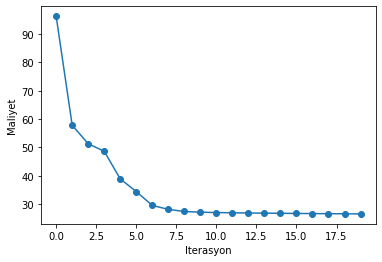

In [18]:
plt.plot(maliyetler, marker='o')
plt.xlabel("Iterasyon")
plt.ylabel("Maliyet")

Hipotez fonksiyonumuzun ciktisi:

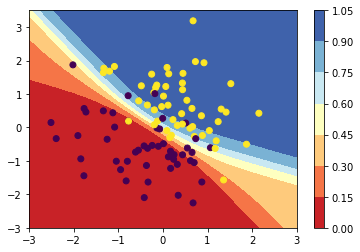

In [19]:
XXravel = np.array([xx.ravel(), yy.ravel()]).T
ZZ1 = XXravel @ beta1 + sabit1
AA1 = sigmoid(ZZ1)
ZZ2 = AA1 @ beta2 + sabit2
AA2 = sigmoid(ZZ2)

AA2 = AA2.reshape(xx.shape)

plt.contourf(xx, yy, AA2, cmap='RdYlBu')
plt.colorbar()
plt.scatter(*X.T, c=y)

Kodumuzu daha moduler bir hale getirmek icin, parcalari tekrar tekrar kullanilabilir fonksiyonlara cevirelim:

In [20]:
def feedForward(X, beta1, sabit1, beta2, sabit2):
    """Ileri beslemeyi tatbik et.
    
    Ileri besleme, verilen datanin katsayilarla carpilip sabitlerle toplanmasi
    ve belirlenen donusumlerin yapilmasindan sonra hipotez fonksiyonunun
    ciktisinin alinmasi islemi olacaktir.
    """
    z1 = X @ beta1 + sabit1
    a1 = sigmoid(z1)
    z2 = a1 @ beta2 + sabit2
    yhat = sigmoid(z2)
    return yhat, a1

def backPropagate(X, y, beta1, sabit1, beta2, sabit2, a1, yhat, alpha):
    """Geri yayilimi tatbik et.
    
    Ileri beslemede elde edilen hatanin, sistem boyunca geri dogru yayilarak
    katsayi ve sabitlerin guncellenmesini saglayan fonksiyon.
    """
    dyhat = (1 - y) / (1 - yhat) - (y / yhat)
    dz2 = yhat * (1 - yhat) * dyhat
    dbeta2 = a1.T @ (dz2)
    dsabit2 = (dz2).sum()

    da1 = dz2 @ beta2.T
    dz1 = a1 * (1 - a1) * da1
    dbeta1 = X.T @ dz1
    dsabit1 = dz1.sum(axis=0)

    beta1 = beta1 - alpha * dbeta1
    sabit1 = sabit1 - alpha * dsabit1

    beta2 = beta2 - alpha * dbeta2
    sabit2 = sabit2 - alpha * dsabit2
    return beta1, sabit1, beta2, sabit2

#### Daha kompleks karar sinirlari

Elimizdeki sistemi kullanarak, daha zor (lineer olarak ayrilmayan) bir verisetini tasniflendirmeyi deneyebiliriz.

In [29]:
X, y = datasets.make_circles()
y1 = y[:, None]

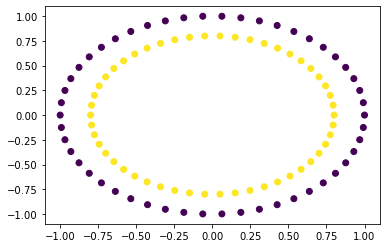

In [30]:
plt.scatter(*X.T, c=y);

Asagidaki interaktif hucrede iterasyonlara sari olarak hipotez fonksiyonunun ciktisinin degisimini gozlemleyebilirsiniz.

> Ek olarak, sagdaki sekilde gizli katmanin ciktisini (3 boyutlu) gormektesiniz.

In [31]:
def graphviz(iterasyon=0):

    # Baslangic degerleri
    np.random.seed(42)
    GIZLI_KATMAN_BOYUTU = 3
    beta1 = np.random.randn(2, GIZLI_KATMAN_BOYUTU)
    sabit1 = np.zeros(GIZLI_KATMAN_BOYUTU)
    beta2 = np.random.randn(GIZLI_KATMAN_BOYUTU, 1)
    sabit2 = 0.0
    alpha = 1e-2

    # Diyagnostik icin
    maliyetler = []

    # Optimizasyon
    for _ in range(iterasyon):
        yhat, a1 = feedForward(X, beta1, sabit1, beta2, sabit2)
        beta1, sabit1, beta2, sabit2 = backPropagate(X, y1, beta1, sabit1, beta2, sabit2, a1, yhat, alpha)

        maliyet = bce(y1, yhat)
        maliyet = np.sum(maliyet)
        maliyetler.append(maliyet)

    # Gorseller
    olasi = feedForward(np.array([xx.ravel(), yy.ravel()]).T, beta1, sabit1, beta2, sabit2)[0]    
    olasi = olasi.reshape(xx.shape)

    fig = plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, olasi, vmin=0, vmax=1, cmap=plt.cm.bone_r, levels=40)
    plt.colorbar().set_label('$\hat{y}$')
    plt.scatter(*X.T, c=y, edgecolors='k')
    plt.title("Hipotez fonksiyonu ciktisi (dataset uzayi)")

    if iterasyon > 0:
        # fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1,2, 2,projection='3d', elev=45, azim=45)
        ax.scatter(a1[:, 0], a1[:, 1], a1[:, 2], c=y)
        ax.set_title("Gizli katman ciktisi (Gizli katman uzayi)")
        ax.set_xlabel("$hucre_1$")
        ax.set_ylabel("$hucre_2$")
        ax.set_zlabel("$hucre_3$")
    else:
        ax = fig.add_subplot(1,2, 2,projection='3d', elev=45, azim=45)
        ax.set_title("Gizli katman ciktisi (Gizli katman uzayi)")
        ax.set_xlabel("$hucre_1$")
        ax.set_ylabel("$hucre_2$")
        ax.set_zlabel("$hucre_3$")

interact(iterasyon=(0,5000,100))(graphviz);

interactive(children=(IntSlider(value=0, description='iterasyon', max=5000, step=100), Output()), _dom_classes…

MLP, orjinal dataset uzayini 3 boyutlu (ya da konfigurasyona gore daha da yuksek boyutlu) bir uzaya haritaliyor.

> Bu haritalamada dikkatinizi ceken bir durum var mi? 
>- 5000. iterasyonda, gizli katman uzayinda, siyah ve sari noktalari tam olarak ayirabilecek bir duzlem kullanilabilir mi?
>- Gizli katman uzayinda noktalar, aralarina bir duzlem girebilecek duruma geldiginde soldaki sekilde ne goruyorsunuz?
>- Hipotez fonksiyonu ile siniflar uyumsuzken, gizli katman uzayinda noktalarin durumu nedir?

Benzer bir haritalamayi `moons` datasetinde de inceleyebiliriz:

In [24]:
X, y = datasets.make_moons()
y1 = y[:, None]

In [25]:
# @lru_cache(maxsize=50000)
def graphviz(iterasyon=0):

    # Baslangic degerleri
    np.random.seed(42)
    GIZLI_KATMAN_BOYUTU = 3
    beta1 = np.random.randn(2, GIZLI_KATMAN_BOYUTU)
    sabit1 = np.zeros(GIZLI_KATMAN_BOYUTU)
    beta2 = np.random.randn(GIZLI_KATMAN_BOYUTU, 1)
    sabit2 = 0.0
    alpha = 1e-2

    # Diyagnostik icin
    maliyetler = []

    # Optimizasyon
    for _ in range(iterasyon):
        yhat, a1 = feedForward(X, beta1, sabit1, beta2, sabit2)
        beta1, sabit1, beta2, sabit2 = backPropagate(X, y1, beta1, sabit1, beta2, sabit2, a1, yhat, alpha)

        maliyet = bce(y1, yhat)
        maliyet = np.sum(maliyet)
        maliyetler.append(maliyet)

    # Gorseller
    olasi = feedForward(np.array([xx.ravel(), yy.ravel()]).T, beta1, sabit1, beta2, sabit2)[0]    
    olasi = olasi.reshape(xx.shape)

    fig = plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, olasi, vmin=0, vmax=1, cmap=plt.cm.bone_r, levels=40)
    plt.colorbar().set_label('$\hat{y}$')
    plt.scatter(*X.T, c=y, edgecolors='k')
    plt.title("Hipotez fonksiyonu ciktisi (dataset uzayi)")

    if iterasyon > 0:
        # fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1,2, 2,
        projection='3d', elev=45, azim=45
        )
        ax.scatter(
            a1[:, 0], 
            a1[:, 1], 
            a1[:, 2], 
            c=y)
        ax.set_title("Gizli katman ciktisi (Gizli katman uzayi)")
        ax.set_xlabel("$hucre_1$")
        ax.set_ylabel("$hucre_2$")
        ax.set_zlabel("$hucre_3$")
    else:
        ax = fig.add_subplot(1,2, 2,
        projection='3d', elev=45, azim=45
        )
        ax.set_title("Gizli katman ciktisi (Gizli katman uzayi)")
        ax.set_xlabel("$hucre_1$")
        ax.set_ylabel("$hucre_2$")
        ax.set_zlabel("$hucre_3$")

interact(iterasyon=(0,5000,100))(graphviz);

interactive(children=(IntSlider(value=0, description='iterasyon', max=5000, step=100), Output()), _dom_classes…

## `sklearn` ile Sinir Agi egitimi

Yukarida bastan olusturdugumuz sinir agi mimarisinin aynisini `sklearn` ile yapalim:

In [26]:
from sklearn import neural_network

model = neural_network.MLPClassifier(
    hidden_layer_sizes=(3,), 
    max_iter=1000, 
    learning_rate_init=0.01,
    activation='logistic',
    solver='lbfgs',
    )
model.fit(X, y)

MLPClassifier(activation='logistic', hidden_layer_sizes=(3,),
              learning_rate_init=0.01, max_iter=1000, solver='lbfgs')

Model ciktilarini gorsellestirelim:

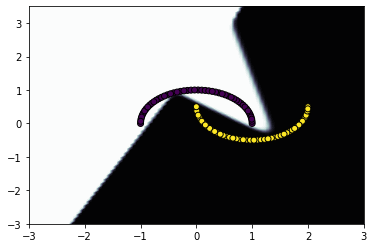

In [27]:

zz = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
plt.contourf(xx, yy, zz, vmin=0, vmax=1, cmap=plt.cm.bone_r, levels=40)
plt.scatter(*X.T, c=y, edgecolors='k');

### Regresyon

Sinir aglari, tasniflendirme icin kullanilabilecegi gibi *regresyon* icin de kullanilabilir.

Bu durumda yapacagimiz degisiklik, cikti katmaninda sigmoid aktivasyonu yerine linear aktivasyon kullanmaktir (yani aktivasyon kullanmamak!)

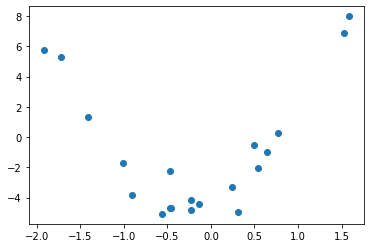

In [28]:
np.random.seed(42)
Q = np.random.randn(20, 1)
f = lambda x: 4*x**2 + 2*x -4.
w = (f(Q)).ravel() + np.random.randn(20)

plt.scatter(Q, w);

Sekildeki dataset icin bir regresyon egrisi olusturmak maksadiyla sinir aglarini kullanalim:

In [33]:
regressor = neural_network.MLPRegressor(
    hidden_layer_sizes=(3,),
    max_iter=1000,
    learning_rate_init=0.01,
    activation='logistic',
    solver='lbfgs',
    )

regressor.fit(Q, w)

MLPRegressor(activation='logistic', hidden_layer_sizes=(3,),
             learning_rate_init=0.01, max_iter=1000, solver='lbfgs')

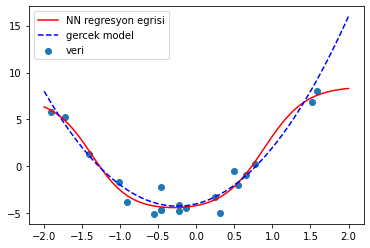

In [34]:
t = np.linspace(-2, 2, 100)
plt.plot(t, regressor.predict(t[:, None]), 'r-', label="NN regresyon egrisi")
plt.plot(t, f(t), 'b--', label="gercek model")
plt.scatter(Q, w, label='veri')
plt.legend();

Daha guclu (daha cok parametre ve derinlige sahip) sinir aglarini kullanarak egriyi neredeyse tum noktalarin uzerinden gecirebilir miyiz?

> 32. dereceden polinomiyel kullandigimiz senaryonun bir benzerinden bahsediyoruz.

In [35]:
regressor = neural_network.MLPRegressor(
    hidden_layer_sizes=(30, 30, 30),
    max_iter=10000,
    learning_rate_init=0.01,
    activation='logistic',
    solver='lbfgs',
    )

regressor.fit(Q, w)

MLPRegressor(activation='logistic', hidden_layer_sizes=(30, 30, 30),
             learning_rate_init=0.01, max_iter=10000, solver='lbfgs')

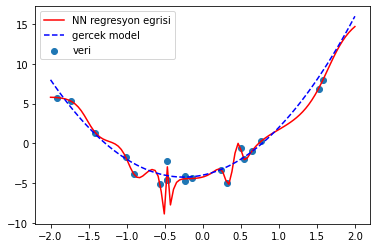

In [36]:
t = np.linspace(-2, 2, 100)
plt.plot(t, regressor.predict(t[:, None]), 'r-', label="NN regresyon egrisi")
plt.plot(t, f(t), 'b--', label="gercek model")
plt.scatter(Q, w, label='veri')
plt.legend();

## Non-lineer aktivasyonlar neden gerekli?

Non-lineer aktivasyonu olmadan, bir sinir agi egitmeyi denersek:
> `activation = 'identity'` kullanarak $A_i = Z_i$ yapiyoruz.

In [65]:
regressor = neural_network.MLPRegressor(
    hidden_layer_sizes=(30, 30, 30),
    max_iter=10000,
    learning_rate_init=0.01,
    activation='identity',
    solver='lbfgs',
    
    )

regressor.fit(Q, w)

MLPRegressor(activation='identity', hidden_layer_sizes=(30, 30, 30),
             learning_rate_init=0.01, max_iter=10000, solver='lbfgs')

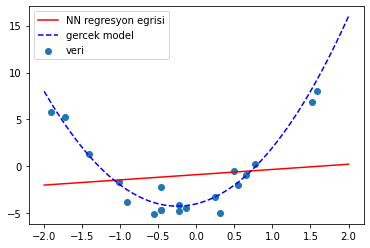

In [66]:
t = np.linspace(-2, 2, 100)
plt.plot(t, regressor.predict(t[:, None]), 'r-', label="NN regresyon egrisi")
plt.plot(t, f(t), 'b--', label="gercek model")
plt.scatter(Q, w, label='veri')
plt.legend();

Egittigimiz 100'lerce parametreli sinir agi, koca bir lineer regresyon modeline donustu.

> Neden?


In [67]:
regressor.predict([[-2]])

array([-2.00538664])

Adim adim sinir agimizin katmanlarini inceleyelim:

In [68]:
z1 = a1 = [[-2]] @ regressor.coefs_[0] + regressor.intercepts_[0]
a1

array([[ 1.05015621, -0.53443281,  0.85406322, -0.54671808,  0.19892822,
         0.71407401, -0.1278388 , -0.11659448, -0.76445368,  0.18891226,
         0.61919162, -0.66127955,  0.08871243, -0.92657817,  0.08119962,
        -0.16352621,  0.9632479 , -0.26014073, -1.01345098, -0.62225413,
         0.67060418,  0.22136151, -0.44536754, -0.96399919,  1.06021378,
         0.45391348,  0.10952593, -0.90415946,  0.66328675,  0.27110532]])

In [69]:
z2 = a2 = a1 @ regressor.coefs_[1] + regressor.intercepts_[1]
a2

array([[-0.78176887,  1.13148821, -0.14590765,  0.19028264, -0.84333338,
        -0.09349726,  0.72471342,  0.22178681, -0.26219031, -1.38348214,
         0.12332167,  0.63375352, -0.24840421,  0.52330347,  0.03240845,
         1.3284465 ,  0.00835841,  0.48788203,  0.54851426,  1.05325892,
         0.66929245, -0.96021797,  0.2970476 ,  1.03603192,  0.31156468,
        -0.34495814,  0.27780616, -0.79222583, -0.77190486, -0.06397768]])

In [70]:
z3 = a3 = a2 @ regressor.coefs_[2] + regressor.intercepts_[2]
a3

array([[-0.01343898, -0.2917772 ,  0.14988523,  0.28343631,  0.4030835 ,
        -0.89288342, -0.32066481,  0.11305408,  0.79692567,  0.08801461,
        -0.55841313, -1.04594078, -0.7008306 ,  0.43330138, -0.74893932,
         0.56917126,  0.83835569,  0.38507272, -0.66946104, -0.85239157,
         1.53264563,  0.95431092,  1.478233  , -0.64951062,  0.62053006,
        -0.10845006, -0.12739517,  0.57744535, -0.45407731, -0.93312272]])

In [71]:
z4 = a4 = a3 @ regressor.coefs_[3] + regressor.intercepts_[3]
a4

array([[-2.00538664]])

Tum bu lineer islemler, yalnizca bir katsayi ve bir interseptle gerceklestirilebilirdi.

In [73]:
regressor.intercepts_[3]

array([0.15822437])

In [82]:
from sklearn import linear_model
lm = linear_model.LinearRegression().fit(Q, w)
lm.coef_, lm.intercept_

(array([0.55579509]), -0.8937051848982577)

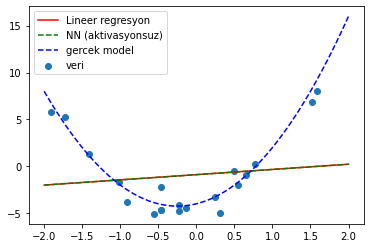

In [84]:
t = np.linspace(-2, 2, 100)
plt.plot(t, lm.predict(t[:, None]), 'r-', label="Lineer regresyon")
plt.plot(t, regressor.predict(t[:, None]), 'g--', label="NN (aktivasyonsuz)")
plt.plot(t, f(t), 'b--', label="gercek model")
plt.scatter(Q, w, label='veri')
plt.legend();